# CBDC ABM Simulation Analysis

This notebook imports the simualtion output and analyzes the output.

The simulation for a toy economy that consists of a number of households, firms, banks and a central bank. Households are employed at firms, are paid for labour, produce output and purchase output. Wages are paid and output is paid for using a combination of deposits at banks and Central Bank Digital Currency.

### Set Parameter values

In [41]:
parameter_values = (('num_sweeps', '31'),
                    ('num_simulations', '50'),
                    ('num_households', '500'),
                    ('num_firms', '40'),
                    ('num_banks', '4'),
                    ('num_ach', '1'),
                    ('num_central_bank', '1'),
                    ('batch', '2'),
                    ('interest_rate_list', 'loans,open_market_operations,loans_central_bank,interbank_deposits'),
                    ('reserves_interest', '0.00'),
                    ('loans_central_bank_interest', '0.003952021'),
                    ('open_market_operations_interest', '0.018372469'),
                    ('loans_interbank_interest', '0.003873535'),
                    ('loans_interest', '0.012958176'),
                    ('deposits_interest', '0.0'),
                    ('clearing_house_fee', '140000'),
                    ('household_directory', 'cluster_folder/agents/gen_households/'),
                    ('firm_directory', 'cluster_folder/agents/gen_firms/'),
                    ('bank_directory', 'cluster_folder/agents/gen_banks/'),
                    ('ach_directory', 'cluster_folder/agents/ach/'),
                    ('central_bank_directory', 'cluster_folder/agents/central_bank/'),
                    ('measurement_config', 'cluster_folder/measurements/test_measurements.xml')
                   )

## Import Simulation Output

Set directory for simulation results

In [43]:
from functools import reduce
import pandas as pd
import glob
import json
thesis_dir = '/Users/jonathanrossouw/Desktop/Sim_res/measurements'

Import the measurements csv

In [49]:

thesis_output = []
thesis_dir_output = glob.glob(thesis_dir + "/*.csv")
for filename in thesis_dir_output:
    thesis_output.append(pd.read_csv(filename, index_col=0))

Import firm balance sheets

In [50]:
firms_output = []
firms_dir = glob.glob(thesis_dir + "/firm*.json")
for filename in firms_dir:
    firms_output.append(json.load(open(filename)))


Import household balance sheets

In [75]:
import json
households_output = []
household_dir = glob.glob(thesis_dir + "/household*.json")
for filename in household_dir:
    households_output.append(json.load(open(filename)))


Import bank balance sheets

In [51]:
banks_output = []
banks_dir = glob.glob(thesis_dir + "/bank*.json")
for filename in banks_dir:
    banks_output.append(json.load(open(filename)))


Import clearing house balance sheets

In [52]:
ach_output = []
ach_dir = glob.glob(thesis_dir + "/ach*.json")
for filename in ach_dir:
    ach_output.append(json.load(open(filename)))


Import central bank balance sheets

In [53]:
central_bank_output = []
central_bank_dir = glob.glob(thesis_dir + "/central*.json")
for filename in central_bank_dir:
    central_bank_output.append(json.load(open(filename)))


## Functions to Read in JSON files into DataFrames

Function to read in json files containing balance sheets and create data frames

In [55]:
# Function that creates a dataframe where each column is the total of each of the different balance sheet entries for a specific type of agent for each simulation step
def json_to_dataframe_total(df, num_sim):
    df_new = pd.DataFrame() # Create empty df
    for item in df: # Loop through list of output from entire step
        balance_h = [] # Create empty list to store balance sheets
        for j in list(item.values()): # Loop through list of agents
            for k in j: # Loop through individual agents
                agent_bal = pd.DataFrame.from_dict(list(k.values())[0], orient="columns") # Create df of balance sheet
                balance_h.append(agent_bal) # Append current agent balance sheet to previous balance sheets


        house_balance = reduce(lambda x, y: x.add(y, fill_value=0), balance_h) # Sum all df together
        house_balance = pd.DataFrame(house_balance.fillna(0).sum(axis=1)) # Replace NA with 0's and sum asset and liabilities side together to made single col
        df_new = pd.concat([df_new, house_balance.T]) # Concat current step total to previous step output rowwise
    df_new.index = range(num_sim) # Reindex to number of steps
    return df_new 

Function to read in json files containing balance sheets and create data frames for specified agent id

In [56]:
# Function that creates a dataframe where each column is a balance sheet entry for a specified agent id for each simulation step
def json_to_dataframe_id(df, num_sim, agent_id):
    df_new = pd.DataFrame() # Create empty df
    for item in df: # Loop through list of output from entire step
        balance_h = [] # Create empty list to store balance sheets
        for j in list(item.values()): # Loop through list of agents
            for k in j: # Loop through individual agents
                if agent_id in k:
                    agent_bal = pd.DataFrame.from_dict(list(k.values())[0], orient="columns") # Create df of balance sheet
                    balance_h.append(agent_bal) # Append current agent balance sheet to previous balance sheets


        house_balance = reduce(lambda x, y: x.add(y, fill_value=0), balance_h) # Sum all df together
        house_balance = pd.DataFrame(house_balance.fillna(0).sum(axis=1)) # Replace NA with 0's and sum asset and liabilities side together to made single col
        df_new = pd.concat([df_new, house_balance.T]) # Concat current step total to previous step output rowwise
    df_new.index = range(num_sim) # Reindex to number of steps
    return df_new 

Function to read in json file containing balance sheet and create dataframe of specific account for all agents of certain type over course of simulation 

In [57]:
# Function that creates dataframe where columns are a specific account type for each agent of certain type for each simulation step
# i.e: cols = [bank_0_deposits, bank_1_deposits, ..., bank_n_deposits]
def json_to_dataframe_account(df, num_sim, account):
    df_new = pd.DataFrame() # Create empty df
    for item in df: # Loop through list of output from entire step
        balance_h = {} # Create empty list to store balance sheets
        for j in list(item.values()): # Loop through list of agents
            for k in j: # Loop through individual agents
                for h in k:
                    for v in k[h].values():
                        try:
                            balance_h[h] = v[account]   
                        except:
                            pass
        agent_bal = pd.DataFrame([balance_h]) # Create df of balance sheet
        df_new = pd.concat([df_new, agent_bal]) # Concat current step total to previous step output rowwise
    df_new.index = range(num_sim) # Reindex to number of steps
    return df_new 

## Summary of Data

In [76]:

num_sim = int(parameter_values[0][1])

# Households
df_household = json_to_dataframe_total(households_output[0], num_sim)

# Firms
df_firm = json_to_dataframe_total(firms_output[0], num_sim)

# Bank

df_bank = json_to_dataframe_total(banks_output[0], num_sim)
col_names = list(df_bank.columns)
col_names = [x for x in col_names if 'ach_payee' in x]

df_bank['ach_payee'] = df_bank[col_names].sum(axis=1)
df_bank = df_bank.drop(columns = col_names)

col_names = list(df_bank.columns)
col_names = [x for x in col_names if 'ach_payer' in x]

df_bank['ach_payer'] = df_bank[col_names].sum(axis=1)
df_bank = df_bank.drop(columns = col_names)


# ACH 
df_ach = json_to_dataframe_total(ach_output[0], num_sim)

# Central Bank
df_central = json_to_dataframe_total(central_bank_output[0], num_sim)

print("Households")
print(df_household.head())
print("Firms")
print(df_firm.head())
print("Banks")
print(df_bank.head())
print("Clearing House")
print(df_ach.head())
print("Central Bank")
print(df_central.head())



Households
       deposits  bank_notes  receivables   equity_firm   equity_bank  loans
0  6.024806e+09         0.0          0.0  2.840710e+09  2.840710e+09    0.0
1  5.871437e+09         0.0          0.0  2.957268e+09  3.037144e+09    0.0
2  5.718069e+09         0.0          0.0  3.073349e+09  3.236988e+09    0.0
3  5.564700e+09         0.0          0.0  3.188947e+09  3.440301e+09    0.0
4  5.411332e+09         0.0          0.0  3.304055e+09  3.647146e+09    0.0
Firms
        capital      deposits  bank_notes  receivables         loans  \
0  2.552439e+09  2.552439e+09         0.0          0.0  2.552439e+09   
1  2.552439e+09  2.685687e+09         0.0          0.0  2.585514e+09   
2  2.552439e+09  2.818935e+09         0.0          0.0  2.619017e+09   
3  2.552439e+09  2.952183e+09         0.0          0.0  2.652955e+09   
4  2.552439e+09  3.085431e+09         0.0          0.0  2.687333e+09   

         equity  
0  2.552439e+09  
1  2.652612e+09  
2  2.752356e+09  
3  2.851666e+09  
4  2

## Plotting Results

In [23]:
import matplotlib.pyplot as plt

Clearing House

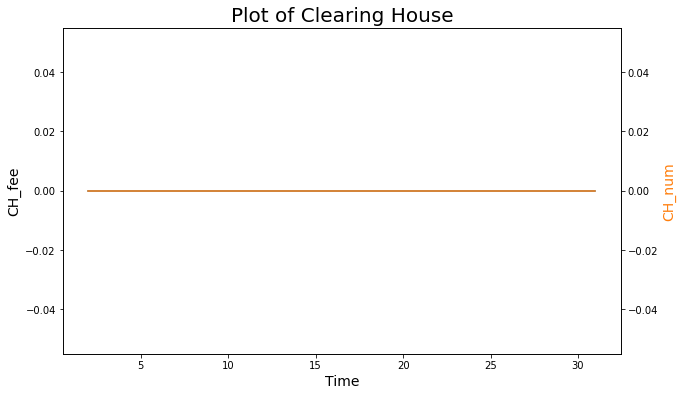

In [62]:
thesis_data_plot = thesis_output[0]

thesis_data_plot[["CH_fee", "CH_num"]] = thesis_data_plot[["clearing_house_fee_total", "number_of_batched_payments"]].diff()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

ax.plot(thesis_data_plot.index, thesis_data_plot[['CH_fee']])
ax.set_xlabel('Time', fontsize='14')
ax.set_ylabel('CH_fee', fontsize='14')

ax2 = ax.twinx()
ax2.plot(thesis_data_plot.index, thesis_data_plot[['CH_num']], color='C1')
ax2.set_xlabel('Time', fontsize='14')
ax2.set_ylabel('CH_num', fontsize='14', color='C1')

plt.title("Plot of Clearing House", size=20)

fig.savefig('figures/ACH_plot.png')

Households

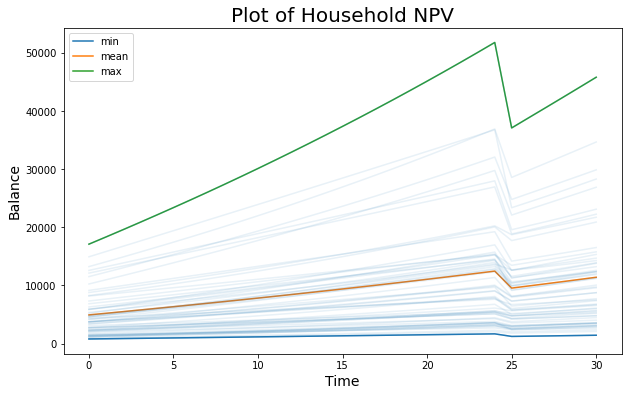

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

household_npv_individual = {}

hh_ids = list(json_to_dataframe_account(households_output[0], num_sim, "loans").columns)
for house in hh_ids:
    household_npv = json_to_dataframe_id(households_output[0], num_sim, house)
    household_npv['npv'] = household_npv[['deposits', 'bank_notes',  'receivables',  'equity_firm' , 'equity_bank']].sum(axis=1) - household_npv['deposits'].values
    household_npv_individual[house] = household_npv['npv']


household_npv_df = pd.DataFrame.from_dict(household_npv_individual)/20000
household_npv_df['max'] = household_npv_df.max(1)
household_npv_df['mean'] = household_npv_df.mean(1)
household_npv_df['min'] = household_npv_df.min(1)

ax.plot(household_npv_df.index, household_npv_df[['min', 'mean', 'max']])
ax.plot(household_npv_df.index, household_npv_df, color='C0', alpha=0.1)
ax.set_xlabel('Time', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'mean', 'max'])
plt.title("Plot of Household NPV", size=20)

fig.savefig('figures/Households_NPVs.png')


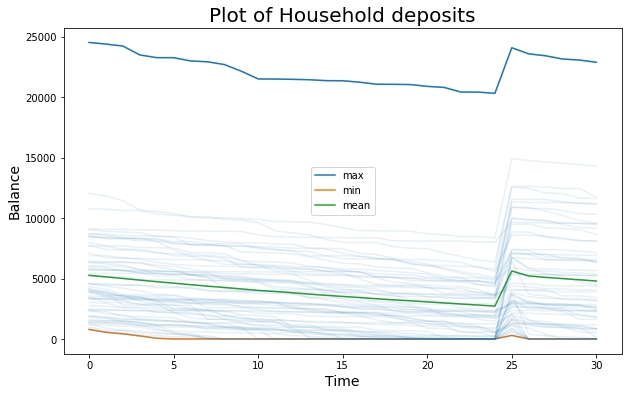

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

# Household
household_deposits = json_to_dataframe_account(households_output[0], num_sim, 'deposits')/20000
household_deposits['max'] = household_deposits.max(axis=1)
household_deposits['min'] = household_deposits.min(axis=1)
household_deposits['mean'] = household_deposits.mean(axis=1)
ax.plot(household_deposits.index, household_deposits[['max', 'min', 'mean']])
ax.plot(household_deposits.index, household_deposits, color='C0', alpha=0.1)
ax.set_xlabel('Time', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['max', 'min', 'mean'])
plt.title("Plot of Household deposits", size=20)

fig.savefig('figures/Households_deposits.png')

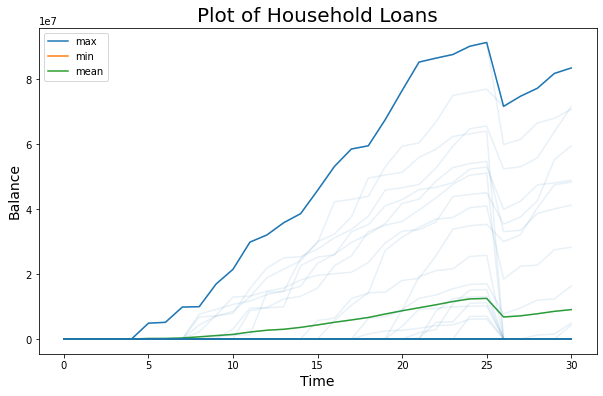

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

# Household
household_loans = json_to_dataframe_account(households_output[0], num_sim, 'loans')
household_loans['max'] = household_loans.max(axis=1)
household_loans['min'] = household_loans.min(axis=1)
household_loans['mean'] = household_loans.mean(axis=1)
ax.plot(household_loans.index, household_loans[['max', 'min', 'mean']])
ax.plot(household_loans.index, household_loans, color='C0', alpha=0.1)
ax.set_xlabel('Time', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['max', 'min', 'mean'])
plt.title("Plot of Household Loans", size=20)

fig.savefig('figures/Households_Loans.png')

Firms

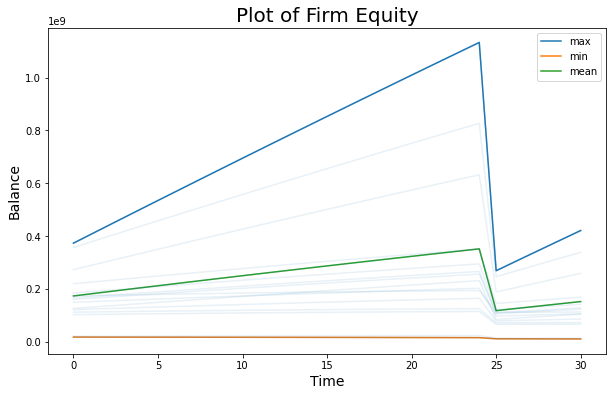

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

# Firms
firm_deposits = json_to_dataframe_account(firms_output[0], num_sim, 'equity')
firm_deposits['max'] = firm_deposits.max(axis=1)
firm_deposits['min'] = firm_deposits.min(axis=1)
firm_deposits['mean'] = firm_deposits.mean(axis=1)
ax.plot(firm_deposits.index, firm_deposits[['max', 'min', 'mean']])
ax.plot(firm_deposits.index, firm_deposits, color='C0', alpha=0.1)

ax.set_xlabel('Time', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['max', 'min', 'mean'])
plt.title("Plot of Firm Equity", size=20)

fig.savefig('figures/Firm_Equity.png')

Banks

/var/folders/nx/sfr0g06x255301jlc_nyn7c00000gn/T/ipykernel_28571/2077304990.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


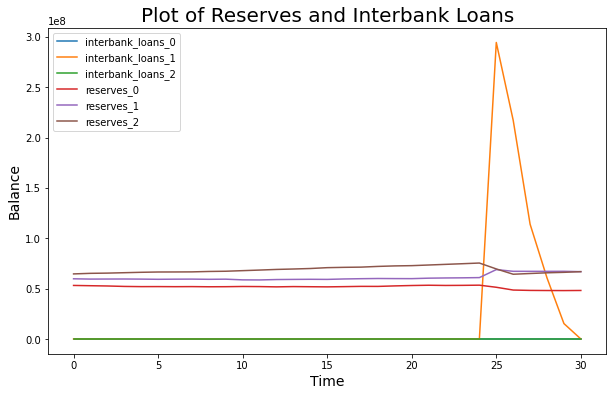

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

# Bank
bank_interbank_loans = json_to_dataframe_account(banks_output[0], num_sim, "interbank_loans")
bank_reserves = json_to_dataframe_account(banks_output[0], num_sim, "reserves")

ax.plot(bank_interbank_loans.index, bank_interbank_loans)
ax.plot(bank_reserves.index, bank_reserves)
ax.set_xlabel('Time', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['interbank_loans_0', 'interbank_loans_1', 'interbank_loans_2', 'reserves_0', 'reserves_1', 'reserves_2'])
plt.title("Plot of Reserves and Interbank Loans", size=20)
fig.show()


fig.savefig('figures/Reserves_IB_Loans.png')

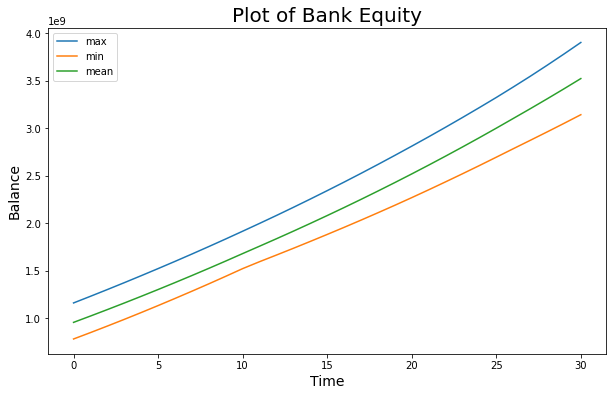

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

# Bank
bank_equity = json_to_dataframe_account(banks_output[0], num_sim, 'equity')
bank_equity['max'] = bank_equity.max(axis=1)
bank_equity['min'] = bank_equity.min(axis=1)
bank_equity['mean'] = bank_equity.mean(axis=1)
ax.plot(bank_equity.index, bank_equity[['max', 'min', 'mean']])
ax.set_xlabel('Time', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['max', 'min', 'mean'])

plt.title("Plot of Bank Equity", size=20)

fig.savefig('figures/Bank_Equity.png')

Text(0.5, 1.0, 'Area Plot of Selected Bank_0 Assets')

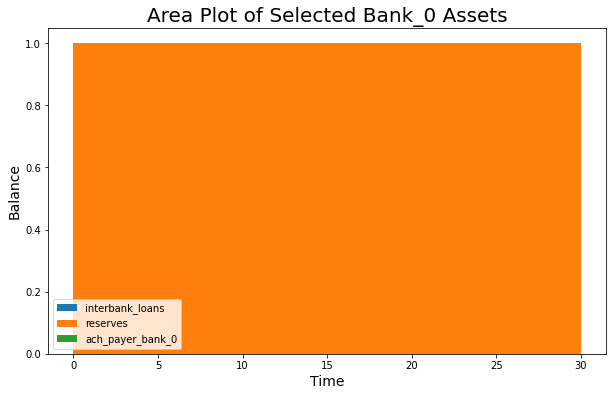

In [72]:
df_bank_0 = json_to_dataframe_id(banks_output[0], num_sim, 'bank_0')

df_bank_plot = df_bank_0[['interbank_loans', 'reserves', 'ach_payer_bank_0']] + 0.01
df_bank_plot = df_bank_plot.divide(df_bank_plot.sum(1), 0)


df_bank_plot_dict = df_bank_plot.to_dict()

for key in df_bank_plot_dict.keys():
    df_bank_plot_dict[key] = list(df_bank_plot_dict[key].values())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
ax.stackplot(df_bank_0.index, df_bank_plot_dict.values(),labels=df_bank_plot_dict.keys())
ax.set_xlabel('Time', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(df_bank_plot.columns, loc=3)
plt.title("Area Plot of Selected Bank_0 Assets", size=20)

Text(0.5, 1.0, 'Area Plot of Selected Bank_0 Liabilities')

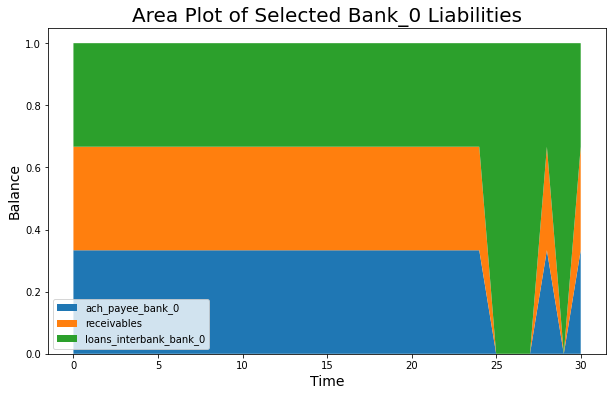

In [73]:
df_bank_plot = df_bank_0[['ach_payee_bank_0', 'receivables', 'loans_interbank_bank_0']] + 0.01
df_bank_plot = df_bank_plot.divide(df_bank_plot.sum(1), 0)


df_bank_plot_dict = df_bank_plot.to_dict()

for key in df_bank_plot_dict.keys():
    df_bank_plot_dict[key] = list(df_bank_plot_dict[key].values())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
ax.stackplot(df_bank_0.index, df_bank_plot_dict.values(),labels=df_bank_plot_dict.keys())
ax.set_xlabel('Time', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(df_bank_plot.columns, loc=3)
plt.title("Area Plot of Selected Bank_0 Liabilities", size=20)


Central Bank

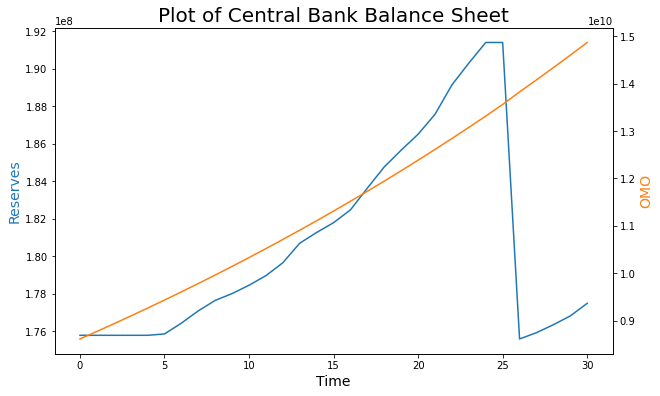

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

# Bank
central_bank_balance_sheet = json_to_dataframe_total(central_bank_output[0], num_sim)

ax.plot(central_bank_balance_sheet.index, central_bank_balance_sheet[['reserves']])
ax.set_xlabel('Time', fontsize='14')
ax.set_ylabel('Reserves', fontsize='14', color='C0')

ax2 = ax.twinx()
ax2.plot(central_bank_balance_sheet.index, central_bank_balance_sheet[['open_market_operations']], color='C1')
ax2.set_xlabel('Time', fontsize='14')
ax2.set_ylabel('OMO', fontsize='14', color='C1')


plt.title("Plot of Central Bank Balance Sheet", size=20)

fig.savefig('figures/CB_Balance_Sheet.png')